# Distance Estimation and Angle Recovery

TODO: put equateions

## Content

1. [Data Preparation](Read-Data)
2. 

## Read Data

Data used:
- Protein: 5j0n (symmetric protein)
- Projections: 5K
- Coverage: Half-sphere

![](figures/5j0n.pdb1-500.jpg)

In [1]:
from numba import cuda
cuda.select_device(0)
cuda.close()

In [2]:
import os
import h5py
import numpy as np
import time

import sys
sys.path.append("../..") 
from cryoem.plots import plot_angles_count
from IPython.display import Image
import matplotlib.pyplot as plt

import tensorflow as tf
from cryoem.conversions import d_q, euler2quaternion
from cryoem.distance_estimation import train_siamese
import ipyvolume as ipv

In [3]:
tf.__version__

'2.1.0'

In [4]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 716006385446593619
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 257096172667298919
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 10677372562650480298
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11322146816
locality {
  bus_id: 2
  numa_node: 1
  links {
  }
}
incarnation: 17167154731856200365
physical_device_desc: "device: 0, name: Tesla K40c, pci bus id: 0000:da:00.0, compute capability: 3.5"
]


In [5]:
PROTEIN="5j0n"#"5a1a"
ROOT_DIR = "../.."
NUM_PROJECTIONS = 5000

In [6]:
# location of *.h5 files
#data_dir = f"{ROOT_DIR}/data"
data_dir = "/mnt/scratch/students/"

# half coverage (AngCoverage=0.5)
projections_filename = f"{PROTEIN}_ProjectionsAngles_ProjNber5000_AngCoverage2.0,1.0,2.0_AngShift0.0,0.0,0.0.h5"

# load structures
data = h5py.File(os.path.join(data_dir, projections_filename), 'r')

print(f"{data['Projections'].shape[0]} projections of images with dimension {data['Projections'].shape[1:]} pixels")
print(f"{data['Angles'].shape[0]} sets of {data['Angles'].shape[1]} ground truth angles of corresponding projection images")

5000 projections of images with dimension (116, 116) pixels
5000 sets of 3 ground truth angles of corresponding projection images


In [7]:
projections = data['Projections']
projections.shape

(5000, 116, 116)

In [8]:
angles_true = np.array(data['Angles'])
angles_true.shape

(5000, 3)

In [9]:
# plot_angles_count(angles_true)

---

## Prepare for training

In [10]:
from sklearn.model_selection import train_test_split
#from cryoem.distance_estimation import create_pairs

In [11]:
X, y = np.array(data['Projections'], dtype=np.float32), np.array(data['Angles'], dtype=np.float32)

#### Global standardization of projections

In [12]:
def global_standardization(X):
    """Does not have all the positive piels
    Ref: https://machinelearningmastery.com/how-to-manually-scale-image-pixel-data-for-deep-learning/""" 
    print(f'Image shape: {X[0].shape}')
    print(f'Data Type: {X[0].dtype}')
    X = X.astype('float32')

    print("***")
    ## GLOBAL STANDARDIZATION
    # calculate global mean and standard deviation
    mean, std = X.mean(), X.std()
    print(f'Mean: {mean:.3f} | Std: {std:.3f}')
    print(f'Min:  {X.min():.3f} | Max: {X.max():.3f}')
    # global standardization of pixels
    X = (X - mean) / std
    # confirm it had the desired effect
    mean, std = X.mean(), X.std()
    print(f'Mean: {mean:.3f} | Std: {std:.3f}')
    print(f'Min:  {X.min():.3f} | Max: {X.max():.3f}')
    
    return X

In [13]:
def positive_global_standardization(X):
    """Has all positive pixels
    Ref: https://machinelearningmastery.com/how-to-manually-scale-image-pixel-data-for-deep-learning/"""
    mean, std = X.mean(), X.std()
    print(f"Mean: {mean:.3f} | Std: {std:.3f}")

    # global standardization of pixels
    X = (X - mean) / std

    # clip pixel values to [-1,1]
    X = np.clip(X, -1.0, 1.0)

    # shift from [-1,1] to [0,1] with 0.5 mean
    X = (X + 1.0) / 2.0

    # confirm it had the desired effect
    mean, std = X.mean(), X.std()
    print(f'Mean: {mean:.3f} | Std: {std:.3f}')
    print(f'Min:  {X.min():.3f} | Max: {X.max():.3f}')
    
    return X

In [14]:
X = global_standardization(X)

Image shape: (116, 116)
Data Type: float32
***
Mean: 0.262 | Std: 1.038
Min:  0.000 | Max: 15.440
Mean: 0.000 | Std: 1.000
Min:  -0.252 | Max: 14.627


In [15]:
# X_max_px = np.max(X)
# X = X/X_max_px
# print(f"Projection images will be normalized to have pixels ranging from 0 to 1 instead of 1 to {X_max_px}")

In [16]:
# # copy grayscale image into 3 channels
# X = np.tile(X[:, :, :,np.newaxis], 3)
# X.shape

In [17]:
# the data, split between train and test sets
train_idx, test_idx = train_test_split(range(NUM_PROJECTIONS), 
                                       test_size=0.33, 
                                       random_state=42)
train_idx, val_idx= train_test_split(train_idx, 
                                     test_size=0.25, 
                                     random_state=1)

train_idx = sorted(train_idx)
val_idx = sorted(val_idx)
test_idx = sorted(test_idx)

np.savez("data/5j0n/5j0n_siamese_idx", train_idx, val_idx, test_idx)

In [18]:
# TRAIN: 0.67 * 0.75 = 0.5025 => 2512 imgs => max pairs: 6 311 400
# TEST:  0.33                 => 1650 imgs => max pairs: 2 722 500
# VAL:   0.67*0.25 = 0.1675   =>  837 imgs => max pairs:   700 569

In [19]:
np.save("data/5j0n/test_idx", test_idx)

In [20]:
data = np.load("data/5j0n/5j0n_siamese_idx.npz")
train_idx, val_idx, test_idx = data["arr_0"], data["arr_1"], data["arr_2"]

In [21]:
X = np.stack((X,)*3, axis=-1)

In [22]:
X.shape

(5000, 116, 116, 3)

# 1. Distance Estimation

### Train the model

In [23]:
from time import time

In [24]:
def sample_pairs(projections, num_pairs, style="random", k=None):
    if not k and style != "random":
        raise ValueError("Please specify k for kNN for sample_pairs method")
    
    if style=="random":
        idx1 = list(np.random.choice(projections, size=num_pairs))
        idx2 = list(np.random.choice(projections, size=num_pairs))
    
    elif style=="knn":
        idx1 = list(np.random.choice(projections, size=num_pairs))
        indices_p, distances_p, A_p = get_knn_projections(k=k)
        idx2 = [indices_p[i][np.random.randint(1, k)] for i in idx1]
 
    elif style=="knn_and_random":
        # select random sample for the first element of pair
        idx1 = list(np.random.choice(projections, size=num_pairs))
        
        # half from kNN
        indices_p, distances_p, A_p = get_knn_projections(k=k)
        idx2_knn = [indices_p[i][np.random.randint(1, k)] for i in idx1[:num_pairs//2]]
        idx2_random = list(np.random.randint(0, num_projections, num_pairs//2))
        # half random
        idx2 = idx2_knn + idx2_random
        
    return idx1, idx2

def create_pairs(x, y, indices, num_pairs):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    
    # Sample some pairs.
    idx1, idx2 = sample_pairs(projections=indices, num_pairs=num_pairs, style="random")
    
    for z1, z2 in zip(idx1, idx2):
        pairs += [[x[z1], x[z2]]]
        labels += [d_q(euler2quaternion(y[z1]), euler2quaternion(y[z2]))]

    pairs = np.array(pairs)
    pairs = pairs.reshape(list(pairs.shape) + [-1])
    labels = np.array(labels)
    labels = tf.cast(labels, dtype=tf.float32)
    return pairs, labels

In [25]:
start_time = time()

training_pairs, training_y = create_pairs(X, y, indices=train_idx, num_pairs=100000)
validation_pairs, validation_y = create_pairs(X, y, indices=val_idx, num_pairs=20000)
# te_pairs, te_y = create_pairs(X, y, indices=test_idx, num_pairs=20000)

print(f"Data created in: {time()-start_time:.0f}s")

Data created in: 1324s


In [26]:
training_pairs.shape

(100000, 2, 116, 116, 3, 1)

In [27]:
training_pairs=training_pairs.squeeze()
validation_pairs = validation_pairs.squeeze()

In [28]:
# !pip install keras-vggface

In [29]:
# !pip install pydot

In [30]:
import os
import h5py
from time import time, strftime
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import pathlib

from cryoem.projections import RotationMatrix
from cryoem.conversions import euler2quaternion, d_q
from cryoem.knn import get_knn_projections

import random
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.python.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, AvgPool2D, Lambda, ZeroPadding2D, Dropout, Concatenate, Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import plot_model, multi_gpu_model
from keras.applications.resnet50 import ResNet50




def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def mae(y_true, y_pred):
    return K.mean(K.abs(y_pred - y_true))

def mse(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true))

def mlp(vects):
    x, y = vects
    Concatenate(axis=-1)
    
def mlp_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def create_siamese_network(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input_x = Input(shape=input_shape)
    #print(input_shape)

    # add Convolution, MaxPool, Conv2D, remove Dropout and Dense
    
#     x = Conv2D(filters=32, kernel_size=[7, 7], activation='relu', padding='same', kernel_initializer='glorot_uniform')(input_x)
#     x = MaxPooling2D([2, 2], padding='same')(x)

#     x = Conv2D(64, [5, 5], activation='relu', padding='same', kernel_initializer='glorot_uniform')(x)
#     x = MaxPooling2D([2, 2], padding='same')(x)

#     x = Conv2D(128, [3, 3], activation='relu', padding='same', kernel_initializer='glorot_uniform')(x)
#     x = MaxPooling2D([2, 2], padding='same')(x)

#     x = Conv2D(256, [3, 3], activation='relu', padding='same', kernel_initializer='glorot_uniform')(x)
#     x = MaxPooling2D([2, 2], padding='same')(x)
    
#     x = Conv2D(256, [3, 3], activation='relu', padding='same', kernel_initializer='glorot_uniform')(x)
#     x = MaxPooling2D([2, 2], padding='same')(x)
    
#     x = Conv2D(512, [3, 3], activation='relu', padding='same', kernel_initializer='glorot_uniform')(x)
#     x = MaxPooling2D([2, 2], padding='same')(x)
    
#     x = Conv2D(512, [3, 3], activation='relu', padding='same', kernel_initializer='glorot_uniform')(x)
#     x = MaxPooling2D([2, 2], padding='same')(x)

#     x = AvgPool2D(pool_size=[8, 8], padding='same')(x)

#     x = tf.squeeze(x, axis=[1,2])
    x = MobileNet(weights='imagenet', include_top=False, input_tensor=input_x).layers[-1].output
    x = GlobalAveragePooling2D()(x)
    
    return Model(input_x, x)

def create_distance_network(input_shape):
    # ref: https://github.com/guanjianyu/DisNet/blob/master/Train_DisNet.py
    # ref: https://project.inria.fr/ppniv18/files/2018/10/paper22.pdf
    input_x = Input(shape=input_shape)

    x = Dense(1024, activation="selu")(input_x)
    x = Dense(512, activation="selu")(x)
    x = Dense(256, activation="selu")(x)
    x = Dense(1, activation="selu")(x)
    
    return Model(input_x, x)



def train_siamese(training_pairs, training_y, validation_pairs, validation_y, epochs, batch_size, learning_rate, plot=True, gpus=None):
    
    mirrored_strategy = tf.distribute.MirroredStrategy()
    
    with mirrored_strategy.scope():
        input_shape = tuple(list(X.shape[1:])) #training_pairs[:, 0].shape[1:]
        print(f"Input images shape {input_shape}")

        # network definition
        input_a = Input(shape=input_shape)
        input_b = Input(shape=input_shape)
        cnn_network = create_siamese_network(input_shape)


        # because we re-use the same instance `cnn_network`,
        # the weights of the network will be shared across the two branches
        processed_a = cnn_network(input_a)
        processed_b = cnn_network(input_b)

        
        distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])
#         siamese_output = Concatenate()([processed_a, processed_b])
#         print(f"Output shape of the SiameseNN {siamese_output.shape}")
#         distance_network = create_distance_network(siamese_output.shape)
#         distance = distance_network(siamese_output)
        
        model = Model([input_a, input_b], distance)  # was m


        # train
        #optimizer = RMSprop()
        optimizer = Adam(learning_rate=learning_rate)

        #model = multi_gpu_model(m, gpus=gpus)

        model.summary()

        plot_model(model, to_file="figures/model_plot.png", expand_nested=True, show_shapes=True, show_layer_names=True)

        
        #model.compile(loss=mse, optimizer=optimizer, metrics=['mae'])
        model.compile(loss=mae, optimizer=optimizer, metrics=['mse'])

        # Create a callback that saves the model's weights
        CHECKPOINT_PATH = f"training/{strftime('%Y%m%d_%H%M%S')}"
        pathlib.Path(CHECKPOINT_PATH).mkdir(parents=True, exist_ok=True)
        backup_callback = ModelCheckpoint(filepath=CHECKPOINT_PATH,
                                          save_weights_only=True,
                                          verbose=1)
        # Create a callback that will show tensorboard data
        LOGS_PATH = f"logs/{strftime('%Y%m%d_%H%M%S')}"
        pathlib.Path(LOGS_PATH).mkdir(parents=True, exist_ok=True)
        logs_callback = TensorBoard(LOGS_PATH, histogram_freq=1)
        
        # Create a callback that will decrease LR if it gets plateau in val_loss
        reduce_on_plateau_callback = ReduceLROnPlateau(monitor="val_loss", 
                                              mode="min", 
                                              factor=0.1, 
                                              patience=20, 
                                              verbose=1)

        history = model.fit([training_pairs[:, 0], training_pairs[:, 1]], training_y,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=([validation_pairs[:, 0], validation_pairs[:, 1]], validation_y),
                    callbacks=[backup_callback, logs_callback, reduce_on_plateau_callback])
        
        model_filename = f"training/{strftime('%Y%m%d_%H%M%S')}.h5"
        model.save(model_filename) 
        print(f"Model saved to: {model_filename}")

        if plot:
            # Get training and test loss histories
            training_loss = history.history['loss']
            val_loss = history.history['val_loss']
            mses = history.history['mse']
            val_mses = history.history['val_mse']

            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))

            # Create count of the number of epochs
            epoch_count = range(1, len(training_loss) + 1)

            # Visualize loss history
            ax1.plot(epoch_count, training_loss, 'r--', label='MAE Training Loss')
            ax1.plot(epoch_count, val_loss, 'b-', label='MAE Validation Loss')
            ax1.legend()
            ax1.set_xlabel('Epoch')
            ax1.set_ylabel('Loss')

            ax2.plot(epoch_count, mses, 'r-', label='MSE Training')
            ax2.plot(epoch_count, val_mses, 'b-', label='MSE Validation')
            ax2.legend()
            ax2.set_xlabel('Epoch')
            ax2.set_ylabel('Loss')
            plt.show();

        return model, history

def plot_results(projections, y_pred, y, strtype):
    if projections.shape[-1] == 1:
        projections = projections.reshape(list(projections.shape[:-2]) +[-1])

    def _inner(i):
        
        plt.imfig, (ax1, ax2) = plt.subplots(1, 2)
        ax1.imshow(projections[i, 0])
        ax2.imshow(projections[i, 1])

        print(f"--- {strtype} Set ---")
        print(f"predicted: {y_pred[i][0]}")
        print(f"true:      {y[i].numpy()}")
        print(f"mse:       {mse(y_pred[i], y[i].numpy())}")
        print(f"mae:       {mae(y_pred[i], y[i].numpy())}")
        
    return _inner

Using TensorFlow backend.


In [31]:
training_pairs.shape

(100000, 2, 116, 116, 3)

In [ ]:
model, history = train_siamese(training_pairs=training_pairs, 
                               training_y=training_y, 
                               validation_pairs=validation_pairs, 
                               validation_y=validation_y,
                              epochs=50,  #500
                              batch_size=256,  #512 latest 
                              learning_rate=0.001,  #0.01 
                              plot=True,
                              gpus=1)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Input images shape (116, 116, 3)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


/home/jbanjac/anaconda3/envs/protein_reconstruction/lib/python3.6/site-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Input images shape (116, 116, 3)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


/home/jbanjac/anaconda3/envs/protein_reconstruction/lib/python3.6/site-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape

Epoch 50/50
 99840/100000 [============================>.] - ETA: 0s - loss: 0.2002 - mse: 0.0607
Epoch 00050: saving model to training/20200507_000104
100000/100000 [==============================] - 508s 5ms/sample - loss: 0.2002 - mse: 0.0607 - val_loss: 0.2219 - val_mse: 0.0743
Model saved to: training/20200507_070831.h5


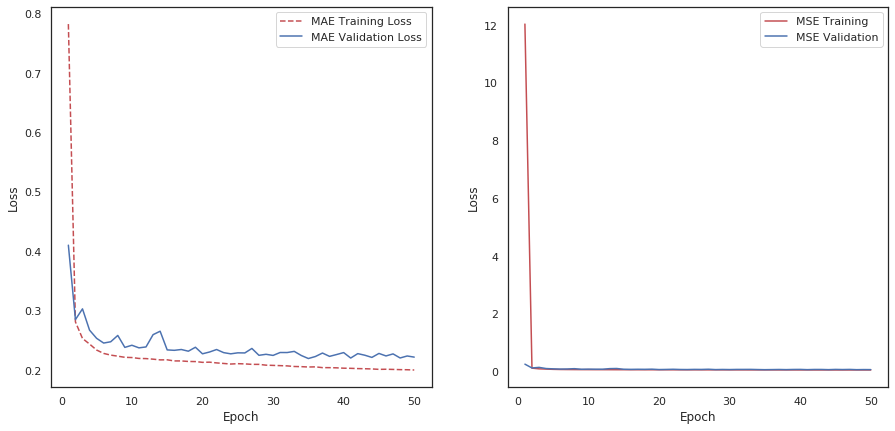

In [32]:
model, history = train_siamese(training_pairs=training_pairs, 
                               training_y=training_y, 
                               validation_pairs=validation_pairs, 
                               validation_y=validation_y,
                              epochs=50,  #500
                              batch_size=256,  #512 latest 
                              learning_rate=0.001,  #0.01 
                              plot=True,
                              gpus=1)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Input images shape (116, 116, 1)
Output shape of the SiameseNN (None, 1024)
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 116, 116, 1) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 116, 116, 1) 0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 512)          4551936     input_1[0][0]                    
                                                                 input_2[0][0]                    
_____________

Epoch 16/100
149760/150000 [============================>.] - ETA: 0s - loss: 0.5469 - mse: 0.4622
Epoch 00016: saving model to training/20200506_113350
150000/150000 [==============================] - 375s 3ms/sample - loss: 0.5469 - mse: 0.4621 - val_loss: 0.5526 - val_mse: 0.4677
Epoch 17/100
149760/150000 [============================>.] - ETA: 0s - loss: 0.5469 - mse: 0.4619
Epoch 00017: saving model to training/20200506_113350
150000/150000 [==============================] - 374s 2ms/sample - loss: 0.5469 - mse: 0.4620 - val_loss: 0.5526 - val_mse: 0.4766
Epoch 18/100
149760/150000 [============================>.] - ETA: 0s - loss: 0.5469 - mse: 0.4624
Epoch 00018: saving model to training/20200506_113350
150000/150000 [==============================] - 375s 2ms/sample - loss: 0.5469 - mse: 0.4623 - val_loss: 0.5545 - val_mse: 0.4599
Epoch 19/100
149760/150000 [============================>.] - ETA: 0s - loss: 0.5469 - mse: 0.4621
Epoch 00019: saving model to training/20200506_11

Epoch 45/100
149760/150000 [============================>.] - ETA: 0s - loss: 0.5459 - mse: 0.4604
Epoch 00045: saving model to training/20200506_113350
150000/150000 [==============================] - 374s 2ms/sample - loss: 0.5460 - mse: 0.4605 - val_loss: 0.5525 - val_mse: 0.4702
Epoch 46/100
149760/150000 [============================>.] - ETA: 0s - loss: 0.5459 - mse: 0.4607
Epoch 00046: saving model to training/20200506_113350
150000/150000 [==============================] - 374s 2ms/sample - loss: 0.5460 - mse: 0.4609 - val_loss: 0.5525 - val_mse: 0.4698
Epoch 47/100
149760/150000 [============================>.] - ETA: 0s - loss: 0.5460 - mse: 0.4605
Epoch 00047: saving model to training/20200506_113350
150000/150000 [==============================] - 375s 2ms/sample - loss: 0.5460 - mse: 0.4606 - val_loss: 0.5526 - val_mse: 0.4679
Epoch 48/100
149760/150000 [============================>.] - ETA: 0s - loss: 0.5460 - mse: 0.4604
Epoch 00048: saving model to training/20200506_11

Epoch 74/100
149760/150000 [============================>.] - ETA: 0s - loss: 0.5460 - mse: 0.4604
Epoch 00074: saving model to training/20200506_113350
150000/150000 [==============================] - 374s 2ms/sample - loss: 0.5460 - mse: 0.4603 - val_loss: 0.5525 - val_mse: 0.4710
Epoch 75/100
149760/150000 [============================>.] - ETA: 0s - loss: 0.5460 - mse: 0.4610
Epoch 00075: saving model to training/20200506_113350
150000/150000 [==============================] - 375s 3ms/sample - loss: 0.5459 - mse: 0.4610 - val_loss: 0.5525 - val_mse: 0.4691
Epoch 76/100
149760/150000 [============================>.] - ETA: 0s - loss: 0.5459 - mse: 0.4600
Epoch 00076: saving model to training/20200506_113350
150000/150000 [==============================] - 376s 3ms/sample - loss: 0.5460 - mse: 0.4601 - val_loss: 0.5525 - val_mse: 0.4705
Epoch 77/100
149760/150000 [============================>.] - ETA: 0s - loss: 0.5459 - mse: 0.4603
Epoch 00077: saving model to training/20200506_11

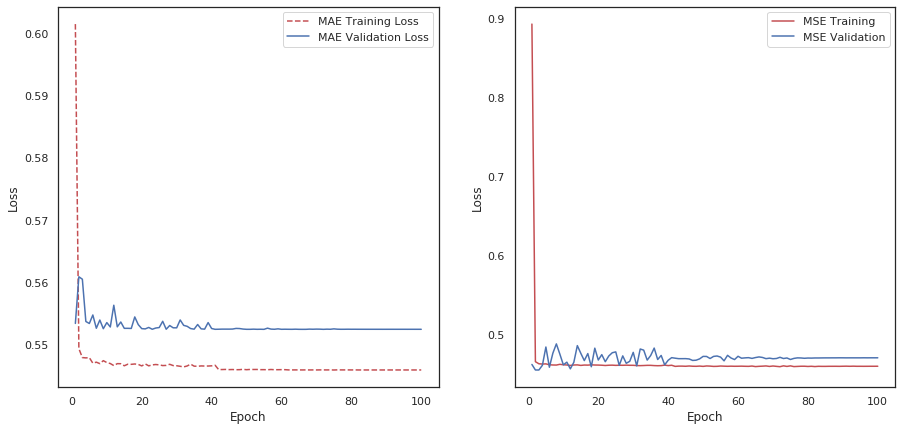

In [30]:
model, history = train_siamese(training_pairs=training_pairs, 
                               training_y=training_y, 
                               validation_pairs=validation_pairs, 
                               validation_y=validation_y,
                              epochs=100,  #500
                              batch_size=256,  #512 latest 
                              learning_rate=0.001,  #0.01 
                              plot=True,
                              gpus=1)

In [ ]:
model, history = train_siamese(training_pairs=training_pairs, 
                               training_y=training_y, 
                               validation_pairs=validation_pairs, 
                               validation_y=validation_y,
                              epochs=50,  #500
                              batch_size=256,  #512 latest 
                              learning_rate=0.001,  #0.01 
                              plot=True,
                              gpus=1)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Input images shape (116, 116, 1)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 116, 116, 1) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 116, 116, 1) 0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 512)          4551936     input_1[0][0]                    
                                                                 input_2[0][0]                    
________________________________________________________

Epoch 20/50
149760/150000 [============================>.] - ETA: 0s - loss: 0.2130 - mse: 0.0677
Epoch 00020: saving model to training/20200505_195745
150000/150000 [==============================] - 366s 2ms/sample - loss: 0.2130 - mse: 0.0677 - val_loss: 0.2356 - val_mse: 0.0857
Epoch 21/50
149760/150000 [============================>.] - ETA: 0s - loss: 0.2125 - mse: 0.0674
Epoch 00021: saving model to training/20200505_195745
150000/150000 [==============================] - 367s 2ms/sample - loss: 0.2125 - mse: 0.0674 - val_loss: 0.2335 - val_mse: 0.0833
Epoch 22/50
149760/150000 [============================>.] - ETA: 0s - loss: 0.2116 - mse: 0.0667
Epoch 00022: saving model to training/20200505_195745
150000/150000 [==============================] - 367s 2ms/sample - loss: 0.2116 - mse: 0.0667 - val_loss: 0.2336 - val_mse: 0.0828
Epoch 23/50
149760/150000 [============================>.] - ETA: 0s - loss: 0.2110 - mse: 0.0665
Epoch 00023: saving model to training/20200505_195745

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Input images shape (116, 116, 1)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 116, 116, 1) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 116, 116, 1) 0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 512)          4551936     input_1[0][0]                    
                                                                 input_2[0][0]                    
________________________________________________________

Epoch 20/50
149760/150000 [============================>.] - ETA: 0s - loss: 0.2371 - mse: 0.0898
Epoch 00020: saving model to training/20200505_140858
150000/150000 [==============================] - 365s 2ms/sample - loss: 0.2370 - mse: 0.0897 - val_loss: 0.3286 - val_mse: 0.1839
Epoch 21/50
149760/150000 [============================>.] - ETA: 0s - loss: 0.2358 - mse: 0.0891
Epoch 00021: saving model to training/20200505_140858
150000/150000 [==============================] - 365s 2ms/sample - loss: 0.2358 - mse: 0.0891 - val_loss: 0.3199 - val_mse: 0.1727
Epoch 22/50
149760/150000 [============================>.] - ETA: 0s - loss: 0.2349 - mse: 0.0886
Epoch 00022: saving model to training/20200505_140858
150000/150000 [==============================] - 365s 2ms/sample - loss: 0.2349 - mse: 0.0886 - val_loss: 0.3141 - val_mse: 0.1658
Epoch 23/50
149760/150000 [============================>.] - ETA: 0s - loss: 0.2340 - mse: 0.0878
Epoch 00023: saving model to training/20200505_140858

Epoch 49/50
149760/150000 [============================>.] - ETA: 0s - loss: 0.2258 - mse: 0.0826
Epoch 00049: saving model to training/20200505_140858
150000/150000 [==============================] - 365s 2ms/sample - loss: 0.2258 - mse: 0.0826 - val_loss: 0.3201 - val_mse: 0.1757
Epoch 50/50
149760/150000 [============================>.] - ETA: 0s - loss: 0.2260 - mse: 0.0825
Epoch 00050: saving model to training/20200505_140858
150000/150000 [==============================] - 365s 2ms/sample - loss: 0.2260 - mse: 0.0825 - val_loss: 0.3068 - val_mse: 0.1595
Model saved to: training/20200505_191430.h5


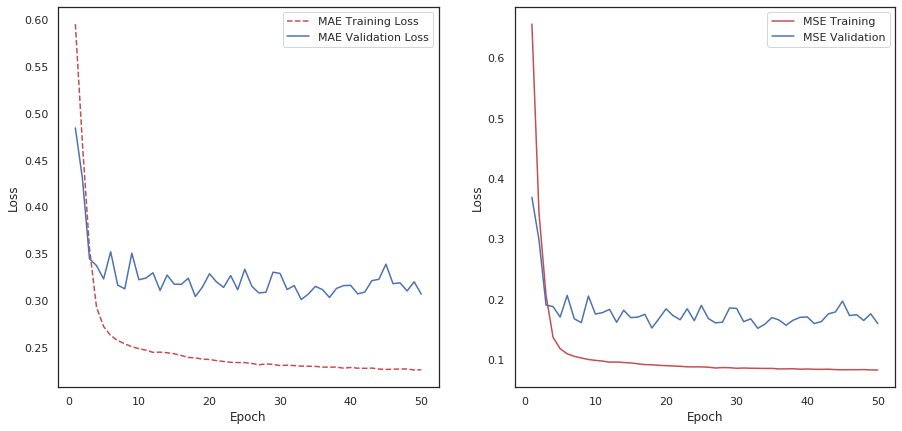

In [31]:
model, history = train_siamese(training_pairs=training_pairs, 
                               training_y=training_y, 
                               validation_pairs=validation_pairs, 
                               validation_y=validation_y,
                              epochs=50,  #500
                              batch_size=256,  #512 latest 
                              learning_rate=0.001,  #0.01 
                              plot=True,
                              gpus=1)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Input images shape (116, 116, 1)
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 116, 116, 1) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 116, 116, 1) 0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 512)          4551936     input_1[0][0]                    
                                                                 input_2[0][0]                    
________________________________________________________

Epoch 45/50
149760/150000 [============================>.] - ETA: 0s - loss: 0.3218 - mse: 0.1839
Epoch 00045: saving model to training/20200504_181520
150000/150000 [==============================] - 368s 2ms/sample - loss: 0.3218 - mse: 0.1839 - val_loss: 0.3676 - val_mse: 0.2383
Epoch 46/50
149760/150000 [============================>.] - ETA: 0s - loss: 0.3208 - mse: 0.1834
Epoch 00046: saving model to training/20200504_181520
150000/150000 [==============================] - 368s 2ms/sample - loss: 0.3208 - mse: 0.1834 - val_loss: 0.3625 - val_mse: 0.2336
Epoch 47/50
149760/150000 [============================>.] - ETA: 0s - loss: 0.3177 - mse: 0.1809
Epoch 00047: saving model to training/20200504_181520
150000/150000 [==============================] - 368s 2ms/sample - loss: 0.3177 - mse: 0.1809 - val_loss: 0.3583 - val_mse: 0.2317
Epoch 48/50
149760/150000 [============================>.] - ETA: 0s - loss: 0.3165 - mse: 0.1803
Epoch 00048: saving model to training/20200504_181520

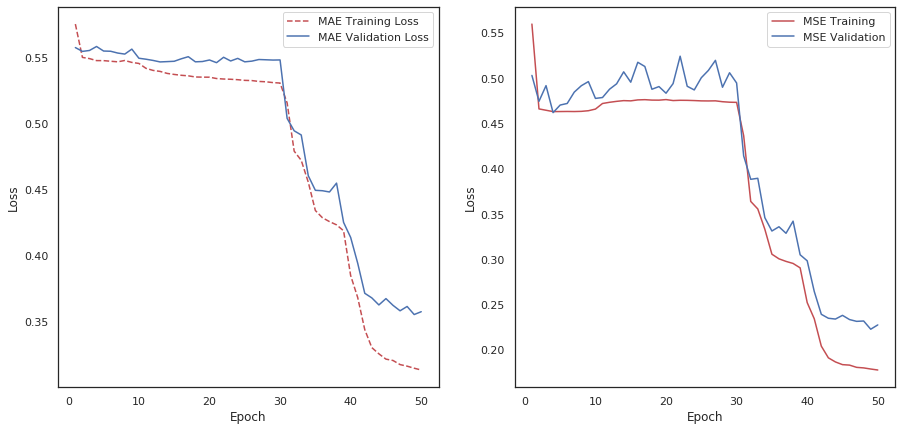

In [37]:
model, history = train_siamese(training_pairs=training_pairs, 
                               training_y=training_y, 
                               validation_pairs=validation_pairs, 
                               validation_y=validation_y,
                              epochs=50,  #500
                              batch_size=256,  #512 latest 
                              learning_rate=0.001,  #0.01 
                              plot=True,
                              gpus=1)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Input images shape (116, 116, 1)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 116, 116, 1) 0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 116, 116, 1) 0                                            
__________________________

Epoch 44/50
149760/150000 [============================>.] - ETA: 0s - loss: 0.2049 - mse: 0.0628
Epoch 00044: saving model to training/20200430_182442
150000/150000 [==============================] - 209s 1ms/sample - loss: 0.2048 - mse: 0.0628 - val_loss: 0.2307 - val_mse: 0.0836
Epoch 45/50
149760/150000 [============================>.] - ETA: 0s - loss: 0.2047 - mse: 0.0628
Epoch 00045: saving model to training/20200430_182442
150000/150000 [==============================] - 210s 1ms/sample - loss: 0.2047 - mse: 0.0628 - val_loss: 0.2285 - val_mse: 0.0808
Epoch 46/50
149760/150000 [============================>.] - ETA: 0s - loss: 0.2046 - mse: 0.0628
Epoch 00046: saving model to training/20200430_182442
150000/150000 [==============================] - 209s 1ms/sample - loss: 0.2046 - mse: 0.0628 - val_loss: 0.2280 - val_mse: 0.0801
Epoch 47/50
149760/150000 [============================>.] - ETA: 0s - loss: 0.2047 - mse: 0.0628
Epoch 00047: saving model to training/20200430_182442

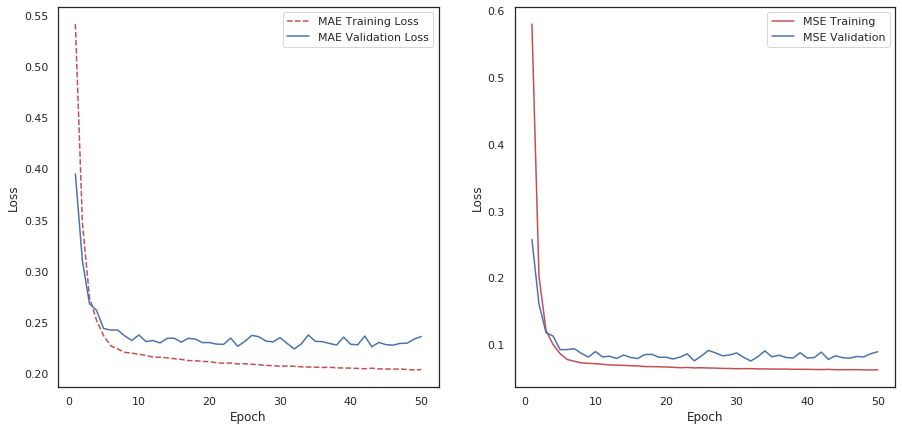

In [41]:
model, history = train_siamese(training_pairs=training_pairs, 
                               training_y=training_y, 
                               validation_pairs=validation_pairs, 
                               validation_y=validation_y,
                              epochs=50,  #500
                              batch_size=256,  #512 latest 
                              learning_rate=0.001,  #0.01 
                              plot=True,
                              gpus=2)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Input images shape (116, 116, 1)
Instructions for updating:
Use `tf.distribute.MirroredStrategy` instead.
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 116, 116, 1) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 116, 116, 1)

Epoch 42/50
149760/150000 [============================>.] - ETA: 0s - loss: 0.2053 - mse: 0.0631
Epoch 00042: saving model to training/20200429_234423
150000/150000 [==============================] - 190s 1ms/sample - loss: 0.2053 - mse: 0.0631 - val_loss: 0.2472 - val_mse: 0.0976
Epoch 43/50
149760/150000 [============================>.] - ETA: 0s - loss: 0.2048 - mse: 0.0628
Epoch 00043: saving model to training/20200429_234423
150000/150000 [==============================] - 190s 1ms/sample - loss: 0.2049 - mse: 0.0628 - val_loss: 0.2411 - val_mse: 0.0922
Epoch 44/50
149760/150000 [============================>.] - ETA: 0s - loss: 0.2048 - mse: 0.0630
Epoch 00044: saving model to training/20200429_234423
150000/150000 [==============================] - 190s 1ms/sample - loss: 0.2048 - mse: 0.0630 - val_loss: 0.2530 - val_mse: 0.1048
Epoch 45/50
149760/150000 [============================>.] - ETA: 0s - loss: 0.2046 - mse: 0.0628
Epoch 00045: saving model to training/20200429_234423

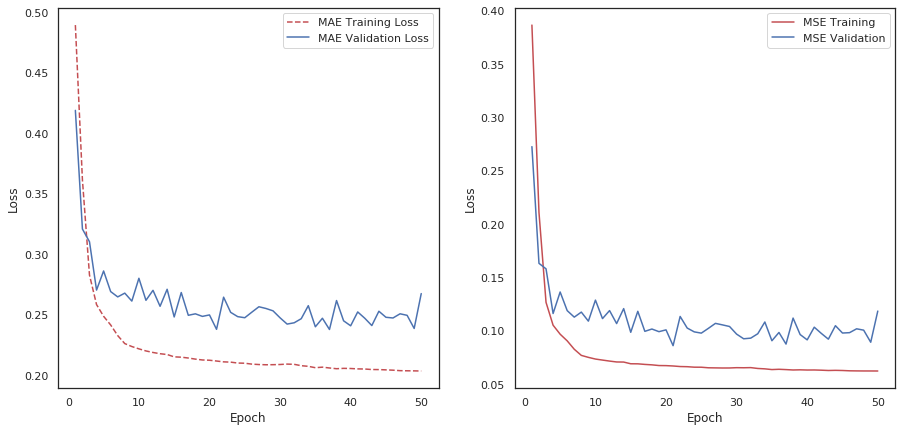

In [31]:
model, history = train_siamese(training_pairs=training_pairs, 
                               training_y=training_y, 
                               validation_pairs=validation_pairs, 
                               validation_y=validation_y,
              epochs=50,  #500
              batch_size=256,  #512 latest 
              learning_rate=0.001,  #0.01 
              plot=True,
              gpus=2)

In [33]:
training_loss = history.history['loss']
val_loss = history.history['val_loss']
mses = history.history['mse']
val_mses = history.history['val_mse']

np.savez("data/5j0n/5j0n_DE_history_full_mobilenet_mlp", training_loss, val_loss, mses, val_mses)

In [34]:
data = np.load("data/5j0n/5j0n_DE_history_full_mobilenet_mlp.npz")
training_loss, val_loss, mses, val_mses = data["arr_0"], data["arr_1"], data["arr_2"], data["arr_3"]

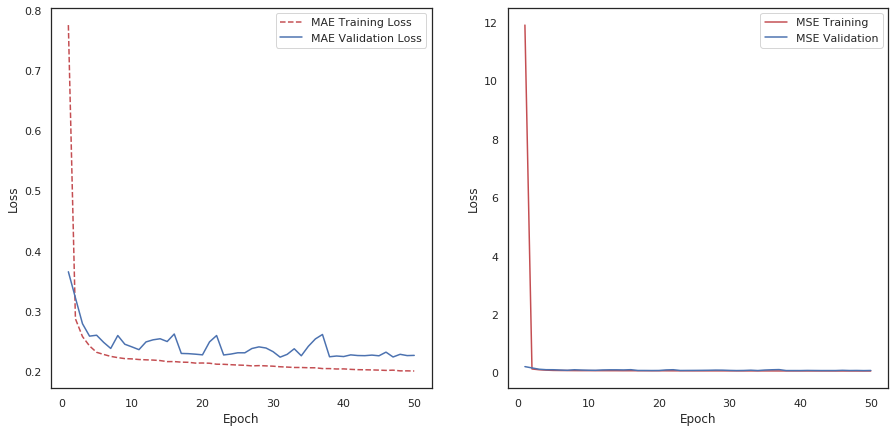

In [35]:
# Get training and test loss histories
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
ax1.plot(epoch_count, training_loss, 'r--', label='MAE Training Loss')
ax1.plot(epoch_count, val_loss, 'b-', label='MAE Validation Loss')
ax1.legend()
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

ax2.plot(epoch_count, mses, 'r-', label='MSE Training')
ax2.plot(epoch_count, val_mses, 'b-', label='MSE Validation')
ax2.legend()
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
plt.show();

In [36]:
training_loss[49], val_loss[49], mses[49], val_mses[49]

(0.19999631774425505, 0.225992813539505, 0.06056869, 0.078284435)

In [37]:
# training_loss[50], val_loss[50], mses[50], val_mses[50]

### (Or) Read model checkpoint

In [40]:
# stop here, change file

In [38]:
# #model_filename = "training/20191218_023743.h5"

# On LTS: "training/20200221_061000.h5"
# model_filename = "training/20200220_055622.h5" local, MSE as loss, 60K training
#model_filename = "training/20200305_055207.h5" # local, MAE as loss, 60K training
#model_filename = "training/20200416_094914.h5"
#model_filename = "training/20200417_192953.h5"
#model_filename = "training/20200418_190002.h5"
#model_filename = "training/20200418_190118.h5" for symmetric
#model_filename = "training/20200422_114231.h5"
#model_filename = "training/20200430_022437.h5" full 2
#model_filename = "training/20200430_212106.h5" full 3
#model_filename = "training/20200504_232357.h5"
#model_filename = "training/20200505_191430.h5"  PGN
#model_filename = "training/20200507_070831.h5" 
model_filename = "training/20200508_020958.h5" # fixed MLP + MobileNet

In [39]:
# Recreate the exact same model, including its weights and the optimizer
model = tf.keras.models.load_model(model_filename)

# Show the model architecture
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 116, 116, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 116, 116, 3) 0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 1024)         3228864     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           model[1][0]                

### Some model results

In [40]:
# from cryoem.distance_estimation import plot_results

In [41]:
# y_tr_pred = model.predict_on_batch([tr_pairs[:256, 0], tr_pairs[:256, 1]])
# y_val_pred = model.predict_on_batch([val_pairs[:256, 0], val_pairs[:256, 1]])

In [42]:
# plot_train_results = plot_results(tr_pairs, y_tr_pred, tr_y, "Train")
# plot_validation_results = plot_results(val_pairs, y_val_pred, val_y, "Validation")

In [43]:
# plot_train_results(1)

In [44]:
# plot_validation_results(0)

---

## dP/dQ plot

In [45]:
from cryoem.conversions import d_q, euler2quaternion
from cryoem.plots import plot_dP_dQ

In [46]:
def d_p(p1, p2):
    dist = []
    p1 = tf.cast(p1, dtype=tf.float32)
    p2 = tf.cast(p2, dtype=tf.float32)

    for i in np.arange(0, len(p1), 256):
        _p1 = p1[i:i+256, :, :]
        _p2 = p2[i:i+256, :, :]
        
        _p1 = tf.convert_to_tensor(_p1)
        #_p1 = tf.expand_dims(_p1, len(_p1.shape)) 
        _p2 = tf.convert_to_tensor(_p2)
        #_p2 = tf.expand_dims(_p2, len(_p2.shape))   #p2 = p2.reshape(list(p2.shape) + [-1]) 

        d = model.predict_on_batch([_p1, _p2])
        d = tf.cast(d, dtype=tf.float64)
        dist.append(d)
    
    dist = tf.concat(dist, axis=0)

    return dist

In [47]:
idx1 = list(np.random.choice(test_idx, size=1000))
idx2 = list(np.random.choice(test_idx, size=1000))

q1_true = euler2quaternion([angles_true[i] for i in idx1])
q2_true = euler2quaternion([angles_true[i] for i in idx2])

p1 = [X[i] for i in idx1]
p2 = [X[i] for i in idx2]

dP_values = d_p(p1, p2).numpy().T[0]
dQ_values = d_q(q1_true, q2_true).numpy()

In [48]:
np.savez("data/5j0n/5j0n_DE_dPdQ_plot_full_mobilenet_mlp", dP_values, dQ_values)

<Figure size 432x288 with 0 Axes>

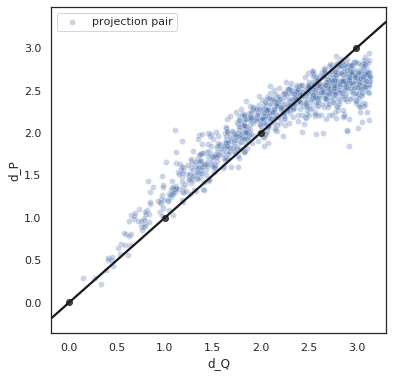

<Figure size 432x288 with 0 Axes>

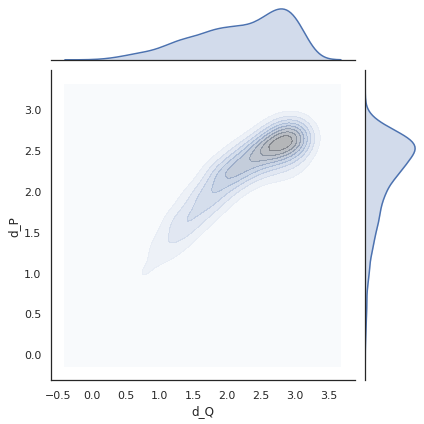

Variance = 0.28616123080732925
Min. angle recovery loss possible = 0.08180636176714842


In [49]:
plot_dP_dQ(dP_values, dQ_values)

In [50]:
idx1 = list(np.random.choice(train_idx, size=1000))
idx2 = list(np.random.choice(train_idx, size=1000))

q1_true = euler2quaternion([angles_true[i] for i in idx1])
q2_true = euler2quaternion([angles_true[i] for i in idx2])

p1 = [X[i] for i in idx1]
p2 = [X[i] for i in idx2]

dP_values = d_p(p1, p2).numpy().T[0]
dQ_values = d_q(q1_true, q2_true).numpy()

<Figure size 432x288 with 0 Axes>

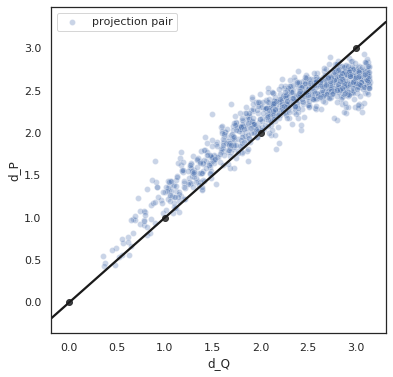

<Figure size 432x288 with 0 Axes>

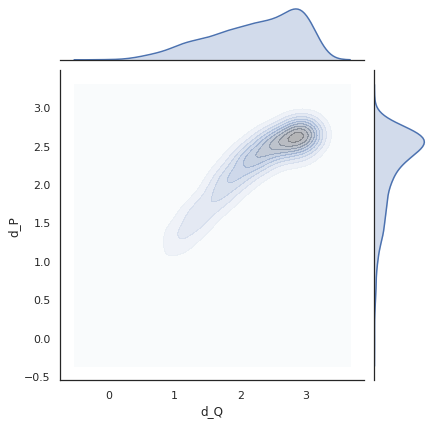

Variance = 0.27162762333860374
Min. angle recovery loss possible = 0.07370778419481779


In [51]:
plot_dP_dQ(dP_values, dQ_values)

# 2. Angle Recovery

## Angle Recovery

Perfect distances. Learning rate 0.01

In [52]:
from cryoem.angle_recovery import train_angle_recovery

In [53]:
# X = tf.cast(X, dtype=tf.float64)
# X = X.numpy()

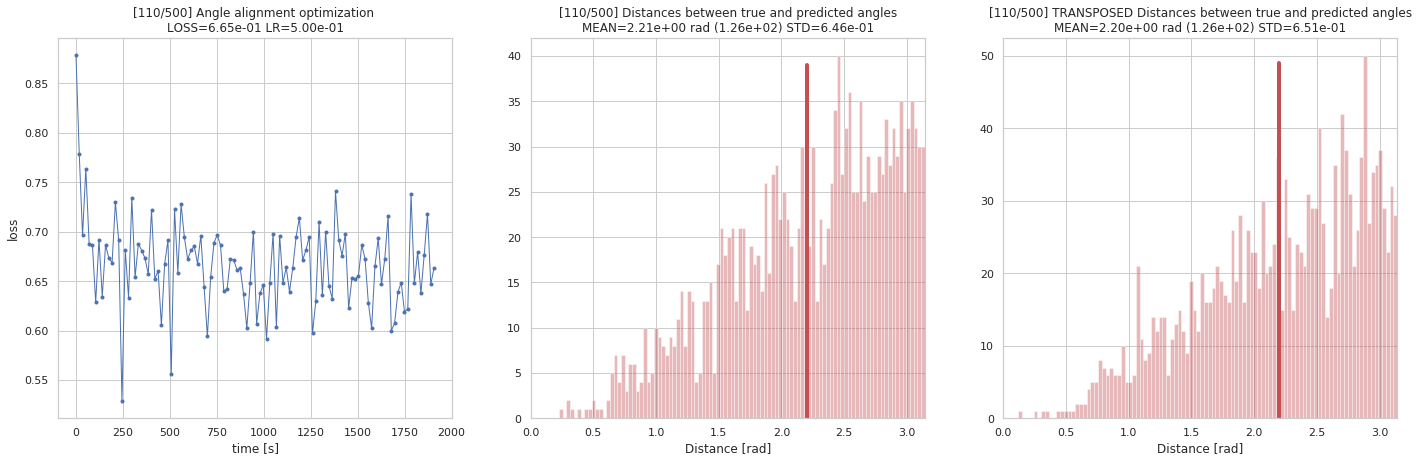

In [ ]:
q_predicted, losses, q_all = train_angle_recovery(steps=500, 
                                                   batch_size=512, 
                                                   in_data=X[test_idx], 
                                                   distance_fn=d_p, 
                                                   learning_rate=0.5,
                                                   angles_true=y[test_idx],
                                                   optimization=True)

In [55]:
np.save("data/5j0n/predicted_quaternions_siamese_losses_full_mobilenet_mlp.npy",     losses)
np.save("data/5j0n/predicted_quaternions_siamese_iterations_full_mobilenet_mlp.npy", q_all)
np.save("data/5j0n/predicted_quaternions_siamese_full_mobilenet_mlp.npy",            q_predicted.numpy())

In [57]:
from cryoem.conversions import quaternion2euler
angles_predicted = quaternion2euler(q_predicted).numpy()%(2*np.pi)
np.save("data/5j0n/predicted_angles_siamese_full_mobilenet_mlp.npy", angles_predicted)

##### Plots

In [59]:
losses      = np.load("data/5j0n/predicted_quaternions_siamese_losses_full_mobilenet_mlp.npy")
q_all       = np.load("data/5j0n/predicted_quaternions_siamese_iterations_full_mobilenet_mlp.npy")
q_predicted = np.load("data/5j0n/predicted_quaternions_siamese_full_mobilenet_mlp.npy")

In [61]:
from cryoem.plots import plot_iterations_polar_plot, plot_iterations_rotvec

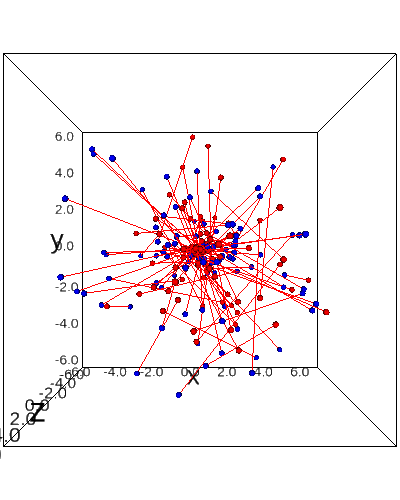

In [65]:
plot_iterations_polar_plot(q_all, angles_true[test_idx], interval=100, selected=range(102));

In [66]:
ipv.screenshot()

Output()

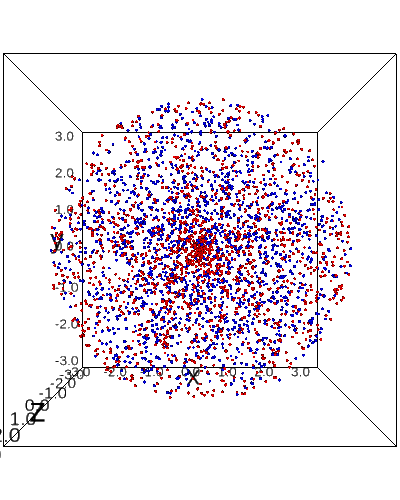

In [67]:
plot_iterations_rotvec(q_all, angles_true[test_idx], interval=100);

In [68]:
ipv.screenshot()

Output()

In [69]:
from cryoem.plots import plot_images

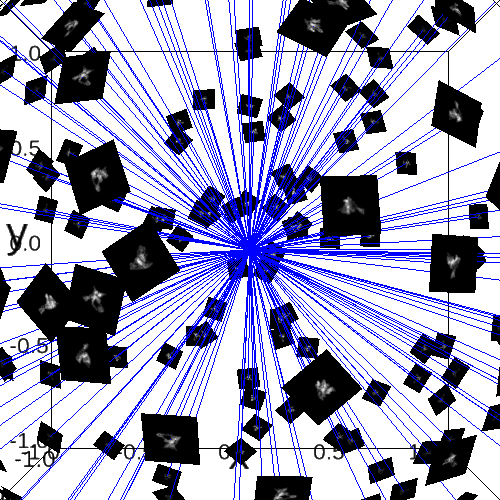

In [70]:
plot_images(angles_predicted, projections, indices=range(200), img_size_scale=0.1)

In [71]:
ipv.screenshot()

Output()

---

# Angle Alignment

#### Prediction angles from previous phase that we want to align with true angles

---

#### Run the Optimization

The `rotation` is our minimizer and we initialize this 6D vector with random values. That is the reason the optimization sometimes converges to 0 loss and sometimes not.

In [77]:
from cryoem.angle_alignment import training_angle_alignment, update_quaternion

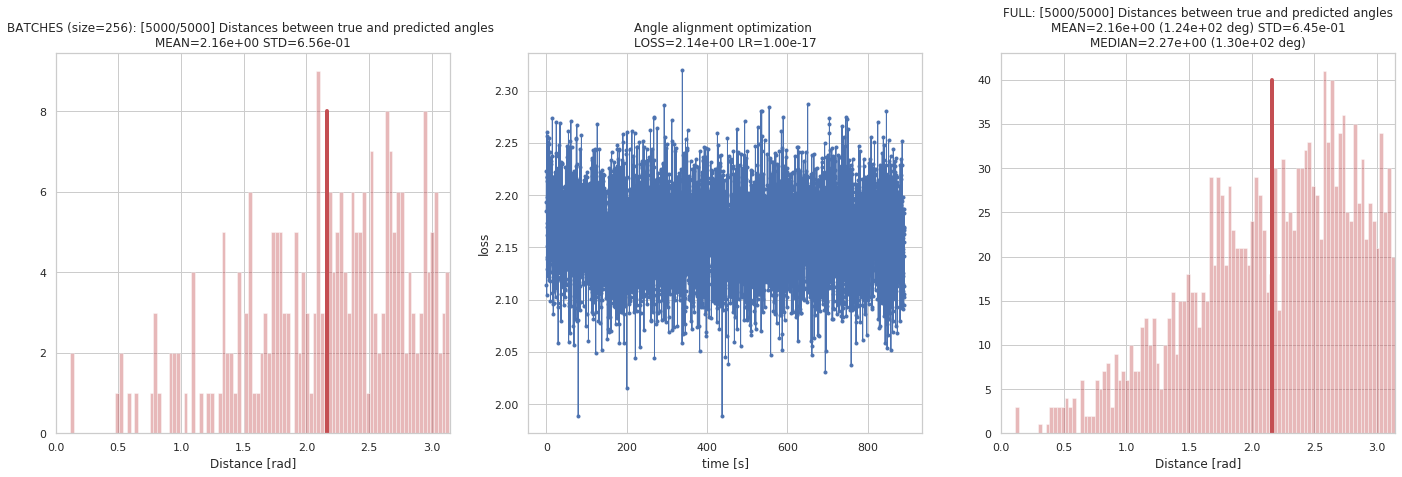

step 500/5000 (96s): loss = 2.17e+00
step 1000/5000 (183s): loss = 2.16e+00
step 1500/5000 (271s): loss = 2.16e+00
step 2000/5000 (358s): loss = 2.16e+00
step 2500/5000 (446s): loss = 2.16e+00
step 3000/5000 (534s): loss = 2.16e+00
step 3500/5000 (622s): loss = 2.16e+00
step 4000/5000 (713s): loss = 2.16e+00
step 4500/5000 (806s): loss = 2.16e+00
step 5000/5000 (892s): loss = 2.16e+00

---


In [80]:
m, rotation, loss, collect_data  = training_angle_alignment(m=[1.0, 1.0, 1.0, 1.0],
                                                 steps=5000, 
                                                 batch_size=256, 
                                                 learning_rate=0.01, 
                                                 angles_true=angles_true[test_idx], 
                                                 angles_predicted=angles_predicted)

In [81]:
m, rotation[0].numpy(), loss[-1]

([1.0, 1.0, 1.0, 1.0],
 array([2.13355493, 3.20832761, 3.42499508, 1.13235032, 6.07880364,
        3.57704655]),
 2.1625712105857064)

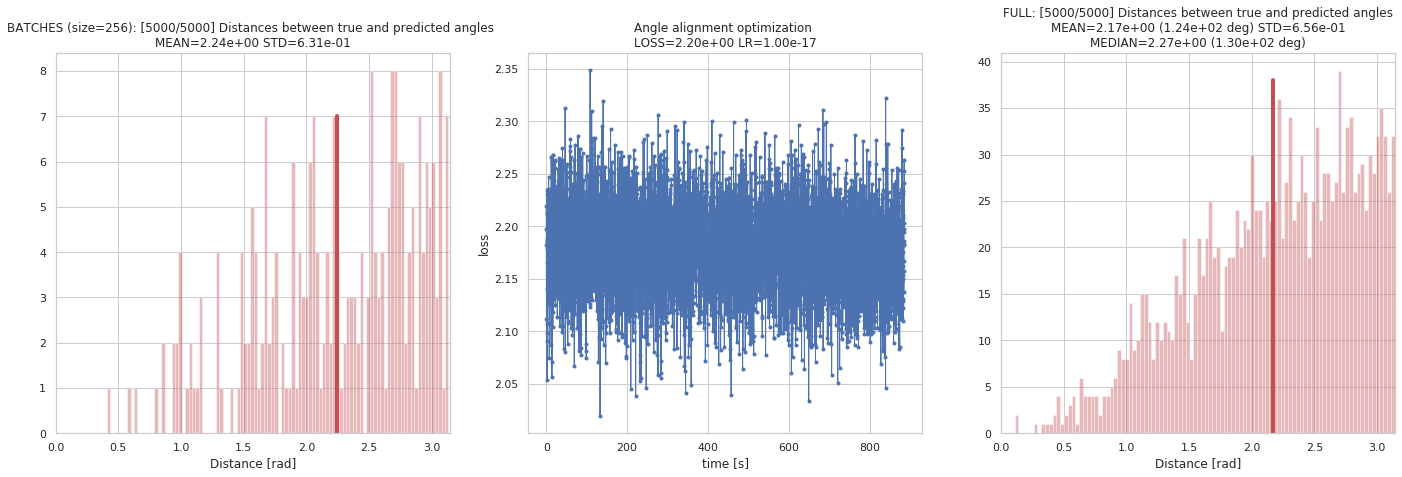

step 500/5000 (89s): loss = 2.18e+00
step 1000/5000 (176s): loss = 2.18e+00
step 1500/5000 (262s): loss = 2.18e+00
step 2000/5000 (349s): loss = 2.18e+00
step 2500/5000 (439s): loss = 2.18e+00
step 3000/5000 (527s): loss = 2.18e+00
step 3500/5000 (617s): loss = 2.18e+00
step 4000/5000 (702s): loss = 2.18e+00
step 4500/5000 (794s): loss = 2.17e+00
step 5000/5000 (886s): loss = 2.17e+00

---


In [75]:
m, rotation, loss, collect_data  = training_angle_alignment(m=[-1.0, 1.0, 1.0, 1.0],
                                                 steps=5000, 
                                                 batch_size=256, 
                                                 learning_rate=0.001, 
                                                 angles_true=angles_true[test_idx], 
                                                 angles_predicted=angles_predicted)

In [76]:
m, rotation[0].numpy(), loss[-1]

([-1.0, 1.0, 1.0, 1.0],
 array([ 1.773942  ,  5.92012581,  2.25840017,  4.82399805,  2.68053836,
        -0.25358452]),
 2.2411800965408157)

##### Plots

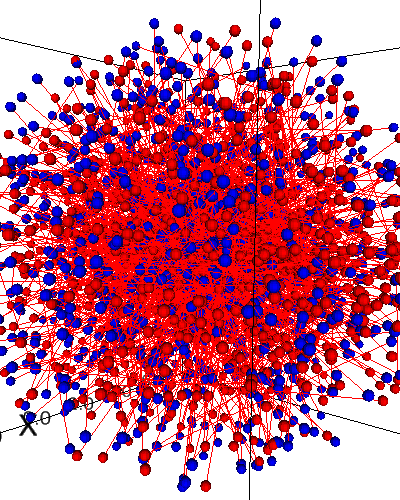

In [83]:
plot_iterations_polar_plot(collect_data, angles_true[test_idx], interval=100);

In [84]:
ipv.screenshot()

Output()

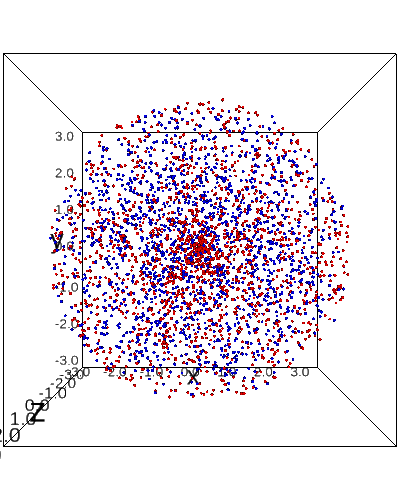

In [85]:
plot_iterations_rotvec(collect_data, angles_true[test_idx]);

In [86]:
ipv.screenshot()

Output()

In [87]:
qpn = euler2quaternion(angles_predicted)

qpa = update_quaternion(m=m, 
                        a_R=rotation, 
                        q_predicted=qpn)

angles_predicted_rotated = quaternion2euler(qpa).numpy()

np.save("data/5j0n/predicted_angles_siamese_updated_full_mlp_mobilenet.npy", angles_predicted_rotated)

In [51]:
# Image(filename='../3-reconstruction/data/5j0n_projections_and_angles_predicted_updated.png')